<a href="https://colab.research.google.com/github/jakechinmk/data_science/blob/main/give_me_credit/notebook/05_xgboost_model_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
- Using feature that derived previously fit into xgboost model

# Setup

In [1]:
!pip install -q optbinning

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from optbinning import BinningProcess, Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

from yellowbrick.classifier import ClassificationReport, ROCAUC 
from yellowbrick.classifier import PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import CVScores
from yellowbrick.model_selection import FeatureImportances

(CVXPY) Apr 26 02:58:04 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 26 02:58:04 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


## Global Configuration

In [3]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/04-feature_engineering_lr_model-train_df.csv'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/04-feature_engineering_lr_model-test_df.csv'
VALID_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/04-feature_engineering_lr_model-valid_df.csv'

TRAIN_CAT_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/04-feature_engineering_lr_model-train_df_cat.csv'
TEST_CAT_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/04-feature_engineering_lr_model-test_df_cat.csv'
VALID_CAT_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/04-feature_engineering_lr_model-valid_df_cat.csv'

OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/'
OUTPUT = True
SEED = 123
TEST_SIZE = 0.3

## Global Function

In [4]:
def classifier_evaluation(model, x_train, y_train, x_test, y_test, cv, scoring):
  fig, axes = plt.subplots(3, 2, figsize=(10, 8))

  visualizer_list = [
      ClassificationReport(model, ax=axes[0][0]),
      ConfusionMatrix(model, ax=axes[0][1]),
      ROCAUC(model, ax=axes[1][0]),
      PrecisionRecallCurve(model, ax=axes[1][1]),
      DiscriminationThreshold(model, ax=axes[2][0]),
      CVScores(model, cv=cv, scoring=scoring, ax=axes[2][1])
  ]

  for i, viz in enumerate(visualizer_list):
    viz.fit(x_train, y_train)
    if i < 4:
      viz.score(x_test, y_test)
    viz.finalize()
  plt.show()

In [5]:
def bucket_evaluation(y_pred_prob:np.ndarray, y_true:pd.Series, bucket:int) -> pd.DataFrame:
    """Evaluate model based on bucket defined

    Args:
        y_pred_prob (np.ndarray): probability predicted using model.
        y_true (pd.Series): true label
        bucket (int): number of bucket.

    Returns:
        pd.DataFrame: Aggregated performance. Similar like CAP graph
    """
    df = pd.DataFrame({
        'pred':y_pred_prob,
        'true':y_true
        })
    df.loc[:, 'bins'], limit = pd.qcut(df.loc[:, 'pred'], 
                                       q=bucket, 
                                       labels=range(1, bucket+1), 
                                       retbins=True
                                       )
    rename_dict = {'sum':'event',
                   'count':'total',
                   }
    agg_df = (df.groupby('bins', as_index=False)['true']
              .agg(['sum', 'count'])
              .rename(columns=rename_dict)
              )
    agg_df.loc[:, 'lower_limit'] = limit[:-1]
    agg_df.loc[:, 'upper_limit'] = limit[1:]
    agg_df.loc[:, 'cumulative_event'] = agg_df.loc[:, 'event'].cumsum()
    agg_df.loc[:, 'cumulative_total'] = agg_df.loc[:, 'total'].cumsum()
    agg_df.loc[:, 'capture_rate'] = (agg_df.loc[:, 'cumulative_event'] 
                                     / agg_df.loc[:, 'event'].sum()
                                     )
    agg_df.loc[:, 'event_rate'] = agg_df.loc[:, 'event'] / agg_df.loc[:, 'total']
    return agg_df

# Data
## Information from Data Dictionary
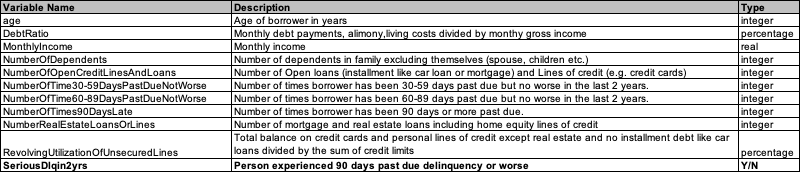

## Read Data

In [6]:
train_df = pd.read_csv(TRAIN_PATH, index_col='Unnamed: 0')
test_df = pd.read_csv(TEST_PATH, index_col='Unnamed: 0')
valid_df = pd.read_csv(VALID_PATH, index_col='Unnamed: 0')

target = 'serious_dlqin_2yrs'

train_df_cat = pd.read_csv(TRAIN_CAT_PATH, index_col='Unnamed: 0').astype('category')
train_df_cat.drop(columns=target, inplace=True)
train_df_cat.columns = [col + '_cat' for col in train_df_cat.columns]

test_df_cat = pd.read_csv(TEST_CAT_PATH, index_col='Unnamed: 0').astype('category')
test_df_cat.drop(columns=target, inplace=True)
test_df_cat.columns = [col + '_cat' for col in test_df_cat.columns]

valid_df_cat = pd.read_csv(VALID_CAT_PATH).astype('category')
valid_df_cat.columns = [col + '_cat' for col in valid_df_cat.columns]

train_df = pd.concat([train_df, train_df_cat], axis=1)
test_df = pd.concat([test_df, test_df_cat], axis=1)
valid_df = pd.concat([valid_df, valid_df_cat], axis=1)

In [7]:
target = 'serious_dlqin_2yrs'
feature_list = train_df.columns.drop(target).tolist()

# Model with more features

In [8]:
x_train = train_df.loc[:, feature_list]
y_train = train_df.loc[:, target]

x_test = test_df.loc[:, feature_list]
y_test = test_df.loc[:, target]

x_valid = valid_df.loc[:, feature_list]

In [9]:
scale_pos_weight =  (y_train.shape[0] - y_train.sum()) / y_train.sum() 

params = {
    'tree_method':'hist',
    'max_cat_to_onehot':10,
    'max_depth':3,
    'eta':0.3,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'scale_pos_weight':scale_pos_weight
}
num_round = 10
nfold = 5
model = xgb.XGBClassifier(enable_categorical=True, **params)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

pipeline = Pipeline(steps=[('xgboost', model)])
pipeline.fit(x_train, y_train)

Pipeline(steps=[('xgboost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eta=0.3,
                               eval_metric='auc', feature_types=None,
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=10, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

## Feature Importance

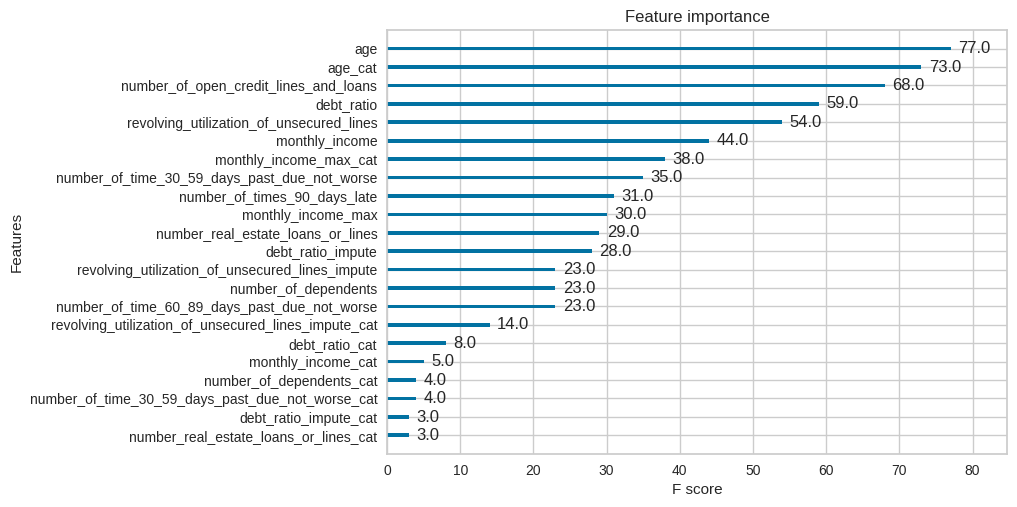

In [10]:
xgb.plot_importance(pipeline.get_params().get('steps')[0][1])
plt.show()

In [11]:
y_pred = pipeline.predict_proba(x_train)[:, 1]

## Train AUC

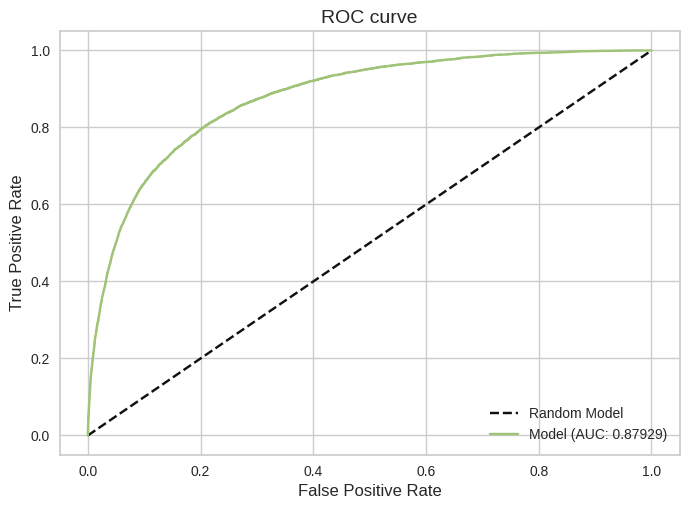

In [12]:
plot_auc_roc(y_train, y_pred)

## Train CAP

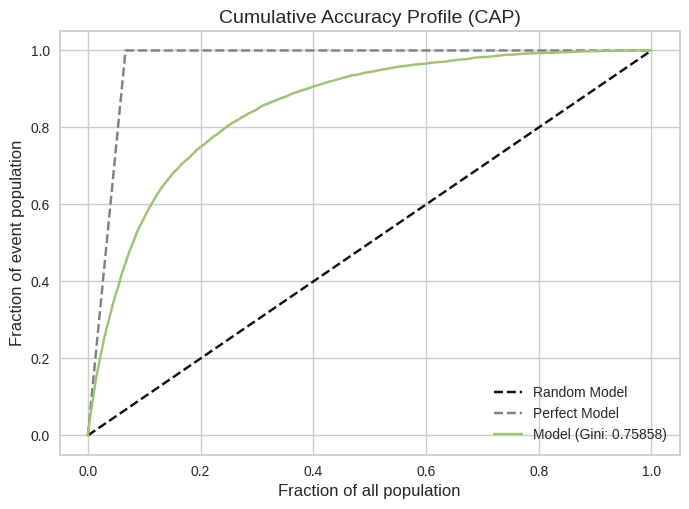

In [13]:
plot_cap(y_train, y_pred)

## Train KS

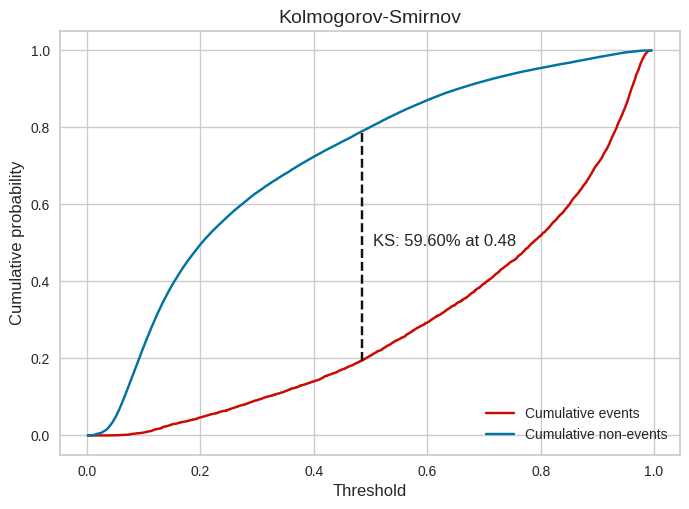

In [14]:
plot_ks(y_train, y_pred)

## Summary on Train Performance
- AUC: 0.88 (0.88)
- Gini: 0.76 (0.76)
- Max KS 59.60 at threshold 0.48

## Bucket Evaluation on Train Data

In [15]:
bucket_evaluation(y_pred_prob=y_pred, y_true=y_train, bucket=10)

,event,total,lower_limit,upper_limit,cumulative_event,cumulative_total,capture_rate,event_rate
bins,,,,,,,,
1,12,10500,0.001408,0.067820,12,10500,0.001709,0.001143
2,35,10501,0.067820,0.095520,47,21001,0.006695,0.003333
3,73,10499,0.095520,0.125479,120,31500,0.017094,0.006953
4,121,10500,0.125479,0.164966,241,42000,0.034330,0.011524
5,152,10500,0.164966,0.221849,393,52500,0.055983,0.014476
6,266,10500,0.221849,0.304396,659,63000,0.093875,0.025333
7,415,10500,0.304396,0.418679,1074,73500,0.152991,0.039524
8,686,10500,0.418679,0.551206,1760,84000,0.250712,0.065333
9,1293,10500,0.551206,0.733727,3053,94500,0.434900,0.123143


## Conclusion on Bucket Evaluation on Train Data
Based on the theshold = 0.48, we can cover about 70% to 80% of the payers (bins no.8) where we only capture 15% (15%) to 15% (25%) of the bad payer.

- The performance is about the same.

- The percentage in bracket indicates for the model in 04-feature_engineering_lr_model.

## Bucket Evaluation on Test Data

In [16]:
y_pred = pipeline.predict_proba(x_test)[:, 1]
bucket_evaluation(y_pred_prob=y_pred, y_true=y_test, bucket=10)

,event,total,lower_limit,upper_limit,cumulative_event,cumulative_total,capture_rate,event_rate
bins,,,,,,,,
1,16,4500,0.001269,0.066970,16,4500,0.005323,0.003556
2,19,4500,0.066970,0.094225,35,9000,0.011643,0.004222
3,48,4500,0.094225,0.124695,83,13500,0.027611,0.010667
4,55,4500,0.124695,0.163636,138,18000,0.045908,0.012222
5,73,4500,0.163636,0.219630,211,22500,0.070193,0.016222
6,103,4500,0.219630,0.301085,314,27000,0.104458,0.022889
7,176,4500,0.301085,0.413127,490,31500,0.163007,0.039111
8,285,4500,0.413127,0.546641,775,36000,0.257818,0.063333
9,527,4500,0.546641,0.730741,1302,40500,0.433134,0.117111


## Conclusion on Bucket Evaluation on Test Data
Based on the theshold = 0.51, we still can cover about 70% to 80% of the payers (bins no.8) where we only capture 16%(15%) to 25%(25%) of the bad payer.

It does not give huge difference though compared to the train performance which meant it's relatively stable.

- The percentage in bracket indicates for the 04-feature_engineering_lr_model.

## Typical Metric Evaluation

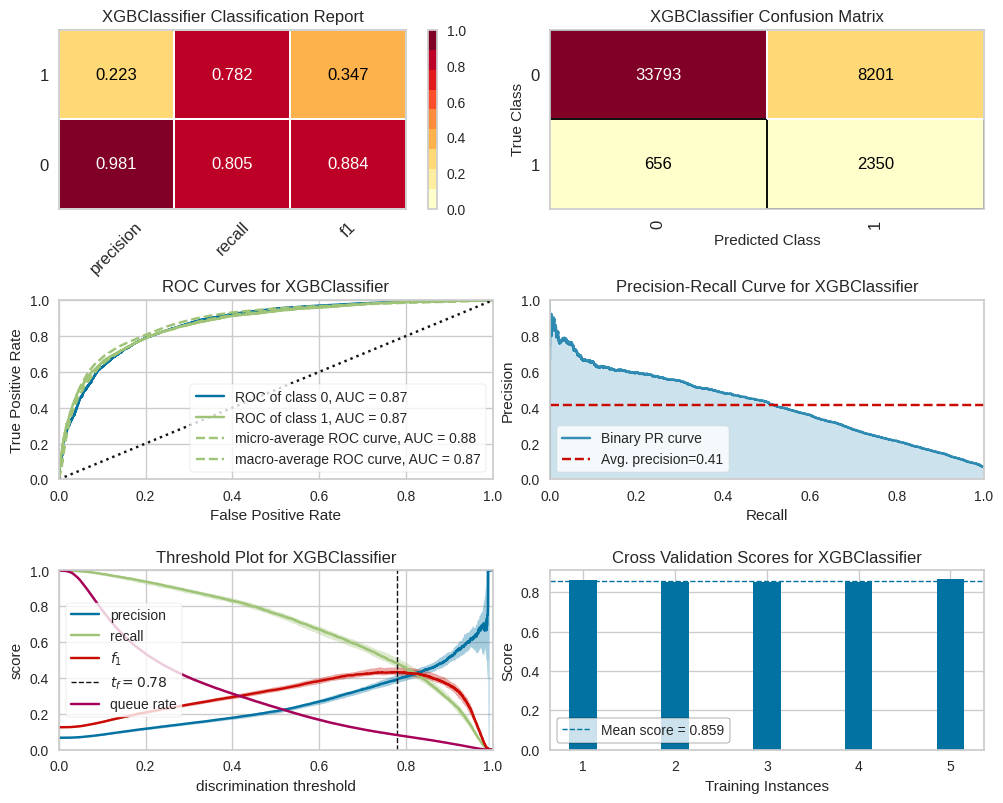

In [17]:
classifier_evaluation(pipeline, x_train, y_train, x_test, y_test, cv, 'roc_auc')

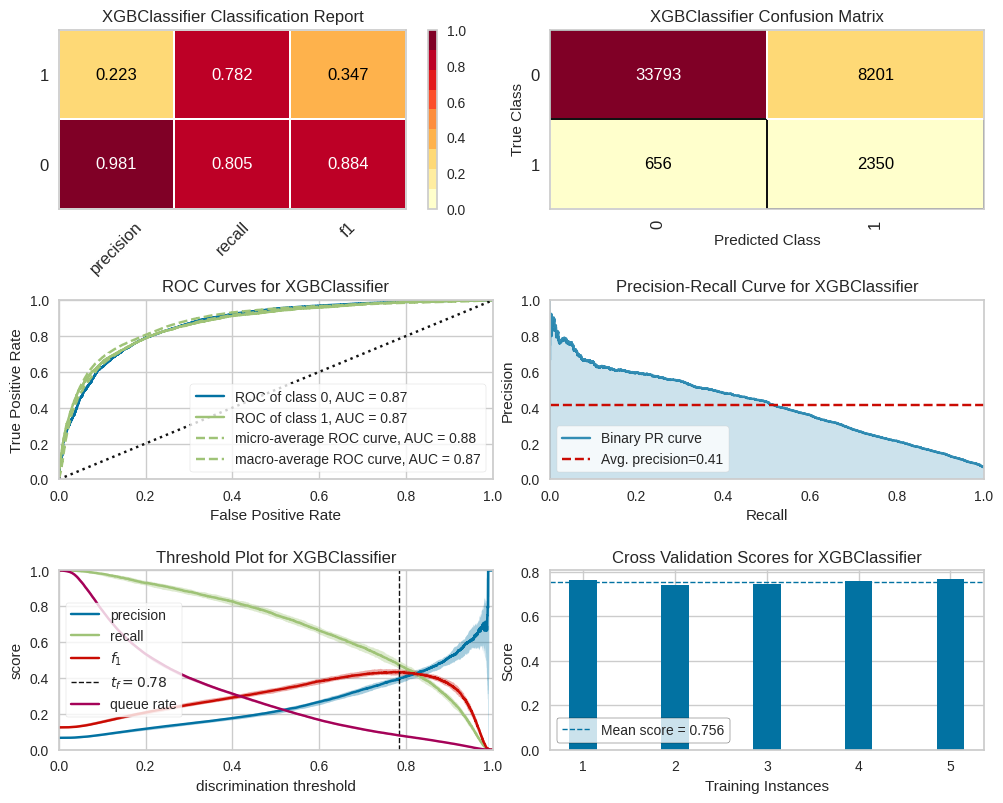

In [18]:
classifier_evaluation(pipeline, x_train, y_train, x_test, y_test, cv, 'recall')

## Summary
- AUC: 0.87 (difference between micro and macro is not that huge)
- Based on the confusion matrix, it's advised to calculate the potential profit that we are losing and potential loss we will incur.
- The discrimination theshold is about 0.78, which meant we should not offer any loan if it exceed 0.78, which in bucket evaluation it will be our last bin (bins no. 10)
- CV: 0.859(0.859) on average but more than 0.8 
- CV Recall: 0.75(0.75) on average
- Based on the metric, even though confusion matrix is showing somewhat a weird value but it's possibly due to threshold setup.
- Hence, looking at the recall metric wise, it's improved compared to the previous model

In general, no difference.

# Output

In [19]:
if OUTPUT:
  joblib.dump(pipeline, f'{OUTPUT_DIR}05-xgboost_model_02-pipeline.pkl')